In [46]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [47]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [48]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy="mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns=cols)

    return (data)

In [49]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [50]:
df = preprocess(data)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size=0.3, random_state=0)
categorical = [x for x in df.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data=x_train.drop(target, axis=1), label=x_train.Stage, categorical_feature=categorical)
test_data =  lgb.Dataset(data=x_test.drop(target, axis=1), label=x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'max_depth': 7,
    'learning_rate': 0.015,
    'max_bin': 300,
    'verbose': 0
}

model = lgb.train(parameters,
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=5000,
                  early_stopping_rounds=500)

[1]	valid_0's binary_logloss: 0.673699
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.661112
[3]	valid_0's binary_logloss: 0.653933
[4]	valid_0's binary_logloss: 0.647007
[5]	valid_0's binary_logloss: 0.640468
[6]	valid_0's binary_logloss: 0.634016
[7]	valid_0's binary_logloss: 0.622722
[8]	valid_0's binary_logloss: 0.616624
[9]	valid_0's binary_logloss: 0.610125
[10]	valid_0's binary_logloss: 0.604214
[11]	valid_0's binary_logloss: 0.598572
[12]	valid_0's binary_logloss: 0.593099
[13]	valid_0's binary_logloss: 0.587554
[14]	valid_0's binary_logloss: 0.577465
[15]	valid_0's binary_logloss: 0.567739
[16]	valid_0's binary_logloss: 0.562406
[17]	valid_0's binary_logloss: 0.557237
[18]	valid_0's binary_logloss: 0.547895
[19]	valid_0's binary_logloss: 0.538874
[20]	valid_0's binary_logloss: 0.53002
[21]	valid_0's binary_logloss: 0.525819
[22]	valid_0's binary_logloss: 0.521828
[23]	valid_0's binary_logloss: 0.517511
[24]	valid_0's binary_loglos

[234]	valid_0's binary_logloss: 0.119185
[235]	valid_0's binary_logloss: 0.118973
[236]	valid_0's binary_logloss: 0.118843
[237]	valid_0's binary_logloss: 0.118659
[238]	valid_0's binary_logloss: 0.118068
[239]	valid_0's binary_logloss: 0.117405
[240]	valid_0's binary_logloss: 0.117157
[241]	valid_0's binary_logloss: 0.116953
[242]	valid_0's binary_logloss: 0.116711
[243]	valid_0's binary_logloss: 0.116497
[244]	valid_0's binary_logloss: 0.115807
[245]	valid_0's binary_logloss: 0.115635
[246]	valid_0's binary_logloss: 0.115051
[247]	valid_0's binary_logloss: 0.114851
[248]	valid_0's binary_logloss: 0.114297
[249]	valid_0's binary_logloss: 0.113691
[250]	valid_0's binary_logloss: 0.113463
[251]	valid_0's binary_logloss: 0.113257
[252]	valid_0's binary_logloss: 0.112745
[253]	valid_0's binary_logloss: 0.112576
[254]	valid_0's binary_logloss: 0.112042
[255]	valid_0's binary_logloss: 0.111846
[256]	valid_0's binary_logloss: 0.111644
[257]	valid_0's binary_logloss: 0.111482
[258]	valid_0's 

[465]	valid_0's binary_logloss: 0.0740361
[466]	valid_0's binary_logloss: 0.0739655
[467]	valid_0's binary_logloss: 0.0739124
[468]	valid_0's binary_logloss: 0.0738618
[469]	valid_0's binary_logloss: 0.0737695
[470]	valid_0's binary_logloss: 0.0736698
[471]	valid_0's binary_logloss: 0.0736161
[472]	valid_0's binary_logloss: 0.073564
[473]	valid_0's binary_logloss: 0.0735428
[474]	valid_0's binary_logloss: 0.0734436
[475]	valid_0's binary_logloss: 0.073407
[476]	valid_0's binary_logloss: 0.0733103
[477]	valid_0's binary_logloss: 0.0732669
[478]	valid_0's binary_logloss: 0.0731986
[479]	valid_0's binary_logloss: 0.0731568
[480]	valid_0's binary_logloss: 0.0731168
[481]	valid_0's binary_logloss: 0.0730632
[482]	valid_0's binary_logloss: 0.0729199
[483]	valid_0's binary_logloss: 0.0728354
[484]	valid_0's binary_logloss: 0.072745
[485]	valid_0's binary_logloss: 0.0726899
[486]	valid_0's binary_logloss: 0.0725569
[487]	valid_0's binary_logloss: 0.0724761
[488]	valid_0's binary_logloss: 0.072

[702]	valid_0's binary_logloss: 0.0628632
[703]	valid_0's binary_logloss: 0.0628303
[704]	valid_0's binary_logloss: 0.0628234
[705]	valid_0's binary_logloss: 0.0628142
[706]	valid_0's binary_logloss: 0.0627911
[707]	valid_0's binary_logloss: 0.0627622
[708]	valid_0's binary_logloss: 0.0627232
[709]	valid_0's binary_logloss: 0.0626984
[710]	valid_0's binary_logloss: 0.0626788
[711]	valid_0's binary_logloss: 0.0626219
[712]	valid_0's binary_logloss: 0.0626137
[713]	valid_0's binary_logloss: 0.0626041
[714]	valid_0's binary_logloss: 0.062613
[715]	valid_0's binary_logloss: 0.0625296
[716]	valid_0's binary_logloss: 0.0624944
[717]	valid_0's binary_logloss: 0.0624439
[718]	valid_0's binary_logloss: 0.0624198
[719]	valid_0's binary_logloss: 0.062401
[720]	valid_0's binary_logloss: 0.0623639
[721]	valid_0's binary_logloss: 0.062353
[722]	valid_0's binary_logloss: 0.0623139
[723]	valid_0's binary_logloss: 0.0622736
[724]	valid_0's binary_logloss: 0.0622303
[725]	valid_0's binary_logloss: 0.062

[971]	valid_0's binary_logloss: 0.0579734
[972]	valid_0's binary_logloss: 0.0579593
[973]	valid_0's binary_logloss: 0.0579521
[974]	valid_0's binary_logloss: 0.0579613
[975]	valid_0's binary_logloss: 0.057971
[976]	valid_0's binary_logloss: 0.0580184
[977]	valid_0's binary_logloss: 0.0580238
[978]	valid_0's binary_logloss: 0.0580314
[979]	valid_0's binary_logloss: 0.0580386
[980]	valid_0's binary_logloss: 0.0580513
[981]	valid_0's binary_logloss: 0.0580256
[982]	valid_0's binary_logloss: 0.0579901
[983]	valid_0's binary_logloss: 0.0579969
[984]	valid_0's binary_logloss: 0.0579943
[985]	valid_0's binary_logloss: 0.0579633
[986]	valid_0's binary_logloss: 0.0579707
[987]	valid_0's binary_logloss: 0.0579461
[988]	valid_0's binary_logloss: 0.0579478
[989]	valid_0's binary_logloss: 0.0579766
[990]	valid_0's binary_logloss: 0.0579592
[991]	valid_0's binary_logloss: 0.0579607
[992]	valid_0's binary_logloss: 0.0579389
[993]	valid_0's binary_logloss: 0.057932
[994]	valid_0's binary_logloss: 0.05

[1206]	valid_0's binary_logloss: 0.0576468
[1207]	valid_0's binary_logloss: 0.0576612
[1208]	valid_0's binary_logloss: 0.0576685
[1209]	valid_0's binary_logloss: 0.0576912
[1210]	valid_0's binary_logloss: 0.0577085
[1211]	valid_0's binary_logloss: 0.0577373
[1212]	valid_0's binary_logloss: 0.057768
[1213]	valid_0's binary_logloss: 0.0577826
[1214]	valid_0's binary_logloss: 0.0578131
[1215]	valid_0's binary_logloss: 0.0578452
[1216]	valid_0's binary_logloss: 0.0578255
[1217]	valid_0's binary_logloss: 0.0578403
[1218]	valid_0's binary_logloss: 0.0578777
[1219]	valid_0's binary_logloss: 0.0578716
[1220]	valid_0's binary_logloss: 0.0578575
[1221]	valid_0's binary_logloss: 0.0578741
[1222]	valid_0's binary_logloss: 0.0578933
[1223]	valid_0's binary_logloss: 0.0578828
[1224]	valid_0's binary_logloss: 0.057866
[1225]	valid_0's binary_logloss: 0.0578715
[1226]	valid_0's binary_logloss: 0.0578554
[1227]	valid_0's binary_logloss: 0.0578345
[1228]	valid_0's binary_logloss: 0.0578232
[1229]	valid_

[1425]	valid_0's binary_logloss: 0.059046
[1426]	valid_0's binary_logloss: 0.0590691
[1427]	valid_0's binary_logloss: 0.0591018
[1428]	valid_0's binary_logloss: 0.0590866
[1429]	valid_0's binary_logloss: 0.0590752
[1430]	valid_0's binary_logloss: 0.059078
[1431]	valid_0's binary_logloss: 0.05911
[1432]	valid_0's binary_logloss: 0.0591063
[1433]	valid_0's binary_logloss: 0.0591435
[1434]	valid_0's binary_logloss: 0.0591544
[1435]	valid_0's binary_logloss: 0.0591227
[1436]	valid_0's binary_logloss: 0.0591172
[1437]	valid_0's binary_logloss: 0.0591358
[1438]	valid_0's binary_logloss: 0.059134
[1439]	valid_0's binary_logloss: 0.059138
[1440]	valid_0's binary_logloss: 0.0591347
[1441]	valid_0's binary_logloss: 0.0591244
[1442]	valid_0's binary_logloss: 0.0591102
[1443]	valid_0's binary_logloss: 0.0591128
[1444]	valid_0's binary_logloss: 0.0591031
[1445]	valid_0's binary_logloss: 0.0590991
[1446]	valid_0's binary_logloss: 0.0590944
[1447]	valid_0's binary_logloss: 0.0591124
[1448]	valid_0's 

[1677]	valid_0's binary_logloss: 0.0613526
Early stopping, best iteration is:
[1177]	valid_0's binary_logloss: 0.0573556


In [52]:
res = model.predict(x_test.drop(target, axis=1))

In [53]:
for x in res[:10]:
    print("{:f}".format(x))

0.000188
0.006219
0.999522
0.999407
0.135966
0.927025
0.003100
0.000033
0.996490
0.000429


In [54]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [55]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [56]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [57]:
log_loss(answer["Stage"], answer["Prediction"])

0.06644938095937941

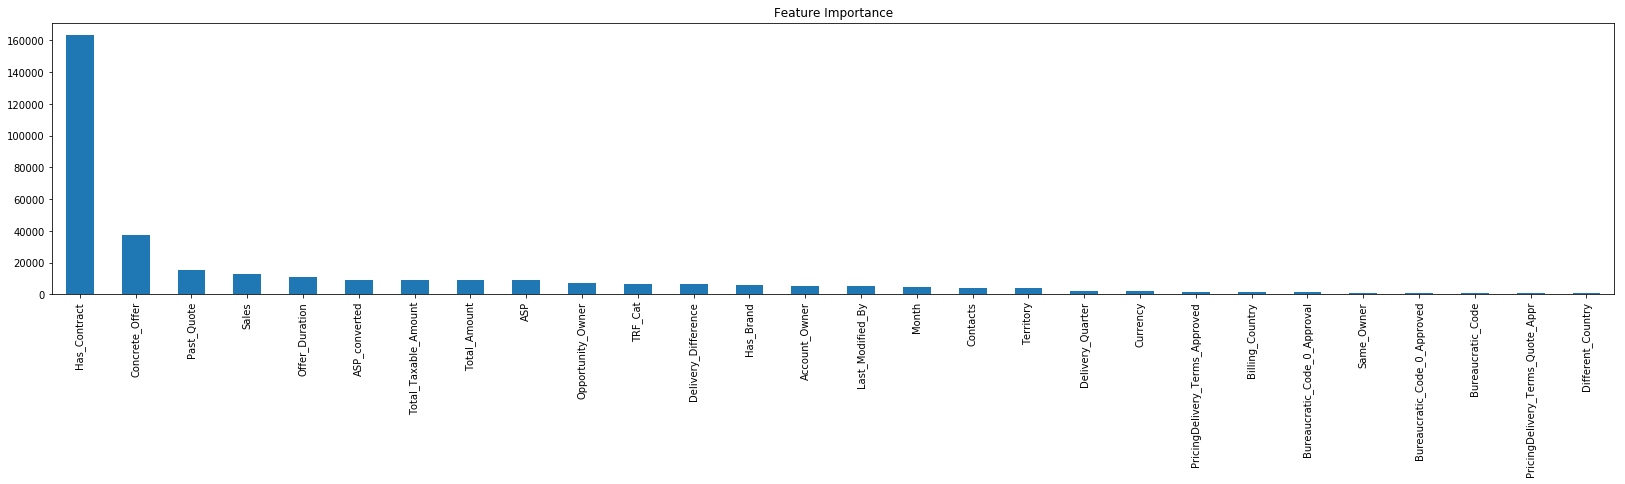

In [58]:
predictors = [x for x in x_train.drop(target, axis=1).columns]
feat_imp = pd.Series(model.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind='bar', title='Feature Importance')

In [59]:
print feat_imp

Has_Contract                        163097.413805
Concrete_Offer                       37401.100655
Past_Quote                           15202.747043
Sales                                12984.901460
Offer_Duration                       10877.801990
ASP_converted                         9249.976731
Total_Taxable_Amount                  9039.670796
Total_Amount                          8817.385124
ASP                                   8745.588778
Opportunity_Owner                     7170.956448
TRF_Cat                               6638.135887
Delivery_Difference                   6422.155923
Has_Brand                             5684.645709
Account_Owner                         5429.592963
Last_Modified_By                      5331.544920
Month                                 4745.909321
Contacts                              4136.982718
Territory                             3792.144408
Delivery_Quarter                      2248.249516
Currency                              2183.644338


In [60]:
vali = pd.read_csv("Validacion_ECI_2020.csv")

In [61]:
validation = preprocess(vali)

In [62]:
len(validation[validation.Contacts > 0])

2551

In [63]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred_vali = model.predict(validation.drop(leak, axis = 1))

In [64]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [65]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [66]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9901387838854021

In [67]:
#answer.to_csv("best/model_xgboost_pred.csv", index = False, header = False)